<a href="https://colab.research.google.com/github/DARoSLab/Adv_robot_dyn_ctrl/blob/main/Lectures/MuJoCo_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**MuJoCo Example**


In [1]:
!pip install mujoco
!pip install mujoco_mjx
!pip install brax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.7/703.7 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.6/998.6 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.5 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94508 sha256=a60361504591350a0465f45a453e82f53f8d126672747e25e5aefdcffc155

In [ ]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [ ]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [ ]:
#@title Import MuJoCo, MJX, and Brax
from datetime import datetime
from etils import epath
import functools
from IPython.display import HTML
from typing import Any, Dict, Sequence, Tuple, Union
import os
from ml_collections import config_dict


import jax
from jax import numpy as jp
import numpy as np
from flax.training import orbax_utils
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from orbax import checkpoint as ocp

import mujoco
from mujoco import mjx

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model


In [ ]:
!git clone https://github.com/DARoSLab/Adv_robot_dyn_ctrl

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cloning into 'Adv_robot_dyn_ctrl'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 103 (delta 27), reused 73 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (103/103), 6.15 MiB | 5.12 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
xml_MiniArm = """
<mujoco>
  <asset>
    <mesh name="arm_base" file="/content/Adv_robot_dyn_ctrl/Meshes/RubatoArmMini/BaseLink.stl" scale="10 10 10"/>
    <mesh name="column_link" file="/content/Adv_robot_dyn_ctrl/Meshes/RubatoArmMini/ColumnLink.stl" scale="10 10 10"/>
    <mesh name="shoulder_pitch" file="/content/Adv_robot_dyn_ctrl/Meshes/RubatoArmMini/ShoulderPitch.stl" scale="10 10 10"/>
    <mesh name="Arm1" file="/content/Adv_robot_dyn_ctrl/Meshes/RubatoArmMini/ArmLink1.stl" scale="10 10 10"/>
    <mesh name="Arm2" file="/content/Adv_robot_dyn_ctrl/Meshes/RubatoArmMini/ArmLink2.stl" scale="10 10 10"/>
    <mesh name="wrist_pitch" file="/content/Adv_robot_dyn_ctrl/Meshes/RubatoArmMini/WristPitch.stl" scale="10 10 10"/>
    <mesh name="EE_link" file="/content/Adv_robot_dyn_ctrl/Meshes/RubatoArmMini/EE_Frame.stl" scale="10 10 10"/>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance=".2"/>
    <material name="red_material" rgba="1 0 0 1"/>  # red
    <material name="orange_material" rgba="1 0.5 0 1"/>  # orange
    <material name="blue_material" rgba="0 0 1 1"/>  # blue
    <material name="green_material" rgba="0 1 0 1"/>  # green
    <material name="yellow_material" rgba="1 1 0 1"/>  # yellow
    <material name="purple_material" rgba="1 0 1 1"/>  # purple
    <material name="pink_material" rgba="1 0.75 0.75 1"/>  # pink
    <material name="white_material" rgba="1 1 1 1"/>  # white
  </asset>
  <visual>
    <global offwidth="700" offheight="400"/>  # Set the offscreen framebuffer height
  </visual>
  <worldbody>
    <geom name="floor" size="0 0 .05" type="plane" material="grid" condim="3"/>

    <camera name="my_camera" pos="1 0 1" euler="30 0 0"/>
    <light name="top" pos="0 0 1"/>

    <body name="base" euler="0 0 0">
      <geom type="mesh" contype="3"  conaffinity="0" group="1" density="0" mesh="arm_base" />

      <body name="colum_link" pos="-0.06 0 0">
        <joint name="base_yaw" type="hinge" axis="0 0 1" pos="0 0 0"/>
        <inertial pos="-0.031984 -1e-08 -0.0289441" quat="0.655781 0.264506 0.264514 0.65576" mass="2.428305" diaginertia="0.00176331 0.00174734 0.000400822"/>
        <geom type="mesh" contype="3"  conaffinity="0" group="1" density="0" mesh="column_link" material="orange_material"/>

        <body name="shoulder_pitch" pos="0 0 0.4">
          <joint name="shoulder_pitch" type="hinge" axis="0 1 0" pos="0 0 0"/>
          <inertial pos="-0.031984 -1e-08 -0.0289441" quat="0.655781 0.264506 0.264514 0.65576" mass="1.428305" diaginertia="0.00176331 0.00174734 0.000400822"/>
          <geom type="mesh" contype="3"  conaffinity="0" group="1" density="0" mesh="shoulder_pitch" material="blue_material"/>

          <body name="UpperArm" pos="0 0 0">
            <joint name="shoulder_roll" type="hinge" axis="1 0 0" pos="0 0 0"/>
            <inertial pos="-0.031984 -1e-08 -0.0289441" quat="0.655781 0.264506 0.264514 0.65576" mass="1.428305" diaginertia="0.00176331 0.00174734 0.000400822"/>
            <geom type="mesh" contype="3"  conaffinity="0" group="1" density="0" mesh="Arm1" material="green_material"/>

            <body name="LowerArm" pos="0.55 0 0">
              <joint name="elbow" type="hinge" axis="0 1 0" pos="0 0 0"/>
              <inertial pos="-0.031984 -1e-08 -0.0289441" quat="0.655781 0.264506 0.264514 0.65576" mass="1.428305" diaginertia="0.00176331 0.00174734 0.000400822"/>
              <geom type="mesh" contype="3"  conaffinity="0" group="1" density="0" mesh="Arm2" material="yellow_material"/>

              <body name="WristPitch" pos="0.45 0 0">
                <joint name="wrist_pitch" type="hinge" axis="0 1 0" pos="0 0 0"/>
                <inertial pos="-0.031984 -1e-08 -0.0289441" quat="0.655781 0.264506 0.264514 0.65576" mass="0.8" diaginertia="0.00176331 0.00174734 0.000400822"/>
                <geom type="mesh" contype="3"  conaffinity="0" group="1" density="0" mesh="wrist_pitch" material="purple_material"/>

                <body name="EE_Frame" pos="0.09 0 0">
                  <joint name="wrist_roll" type="hinge" axis="1 0 0" pos="0 0 0"/>
                  <inertial pos="0.03 0 0" quat="0.655781 0.264506 0.264514 0.65576" mass="0.3" diaginertia="0.00176331 0.00174734 0.000400822"/>
                  <geom type="mesh" contype="3"  conaffinity="0" group="1" density="0" mesh="EE_link" material="pink_material"/>
                </body>
              </body>
            </body>
          </body>
        </body>
      </body>
    </body>
  </worldbody>
<!-- Add actuators for the joints -->
  <actuator>
    <motor joint="base_yaw" ctrlrange="-50 50" gear="1"/>
    <motor joint="shoulder_pitch" ctrlrange="-50 50" gear="1"/>
    <motor joint="shoulder_roll" ctrlrange="-50 50" gear="1"/>
    <motor joint="elbow" ctrlrange="-50 50" gear="1"/>
    <motor joint="wrist_pitch" ctrlrange="-20 20" gear="1"/>
    <motor joint="wrist_roll" ctrlrange="-20 20" gear="1"/>
  </actuator>
</mujoco>
"""

# Make model, data, and renderer
mj_model = mujoco.MjModel.from_xml_string(xml_MiniArm)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model, width=700, height=400)

In [ ]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False

duration = 2.0  # (seconds)
framerate = 40  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)

# Define PD controller gains
kp = 250  # Proportional gain
kd = 3.5  # Derivative gain
desired_position = np.array([0.0, -1.0, 0.0, 1.5, -1.0, 0.0])  # Example desired position

while mj_data.time < duration:# Calculate joint position error
  position_error = desired_position - mj_data.qpos

  # Calculate joint velocity
  velocity = mj_data.qvel

  # Calculate control signal
  control_signal = kp * position_error - kd * velocity

  # Apply control signal to joints
  mj_data.ctrl = control_signal


  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    # mj_data.cam_pos = np.array([1, 0, 1])  # Set camera position
    # mj_data.cam_quat = np.array([1, 0, 0, 0])  # Set camera orientation
    renderer.update_scene(mj_data, scene_option=scene_option)
    # renderer.render(camera_id=0, camera_pos=[1, 0, 1], camera_quat=[1, 0, 0, 0])
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "column_link" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "shoulder_pitch" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "Arm1" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "Arm2" has a coplanar face with more than 20 vertices. This may lead to performance issues and ina

[0. 0. 0. 0. 0. 0.] <class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0.] <class 'jaxlib.xla_extension.ArrayImpl'> {cuda(id=0)}


In [ ]:
jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

In [ ]:
# rng = jax.random.PRNGKey(0)
# rng = jax.random.split(rng, 4096)
# batch = jax.vmap(lambda rng: mjx_data.replace(qpos=jax.random.uniform(rng, (6,))))(rng)

# jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))
# batch = jit_step(mjx_model, batch)

# print(batch.qpos)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# batched_mj_data = mjx.get_data(mj_model, batch)
# print([d.qpos for d in batched_mj_data])

In [ ]:
#@title MiniArm Env
class MiniArm(PipelineEnv):

  def __init__(
      self,
      pos_reward_weight=100.25,
      ctrl_cost_weight=0.01,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_jpos_range=(-3.0, 3.0),
      reset_noise_scale=1e-2,
      **kwargs,
  ):
    mj_model = mujoco.MjModel.from_xml_string(xml_MiniArm)
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    sys = mjcf.load_model(mj_model)

    physics_steps_per_control_step = 2
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)
    kwargs['backend'] = 'mjx'

    super().__init__(sys, **kwargs)

    self._pos_reward_weight = pos_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_jpos_range = healthy_jpos_range
    self._reset_noise_scale = reset_noise_scale

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'pos_reward': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)
    q_des = jp.array([0, -1.0, 0.0, 1.5, -1.0, 0])
    # calculate jpos error
    pos_err = jp.linalg.norm(data.qpos - q_des)
    pos_reward = self._pos_reward_weight * (pos_err)

    min_z, max_z = self._healthy_jpos_range
    is_healthy = jp.where(data.q < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q > max_z, 0.0, is_healthy)
    is_healthy = jp.prod(is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = -pos_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        pos_reward=pos_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes arm jpos."""
    position = data.qpos

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])

envs.register_environment('miniArm', MiniArm)

In [ ]:
# instantiate the environment
env_name = 'miniArm'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

desired_position = np.array([0.0, -1.0, 0.0, 1.5, -1.0, 0.0])  # Example desired position


# grab a trajectory
for i in range(550):
  position_error = desired_position - state.pipeline_state.qpos

  # Calculate joint velocity
  velocity = state.pipeline_state.qvel

  # Calculate control signal
  ctrl = 150 * position_error - 1.5 * velocity
  # ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

media.show_video(env.render(rollout), fps=1.0 / env.dt)

/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "column_link" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "shoulder_pitch" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "Arm1" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "Arm2" has a coplanar face with more than 20 vertices. This may lead to performance issues and ina

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


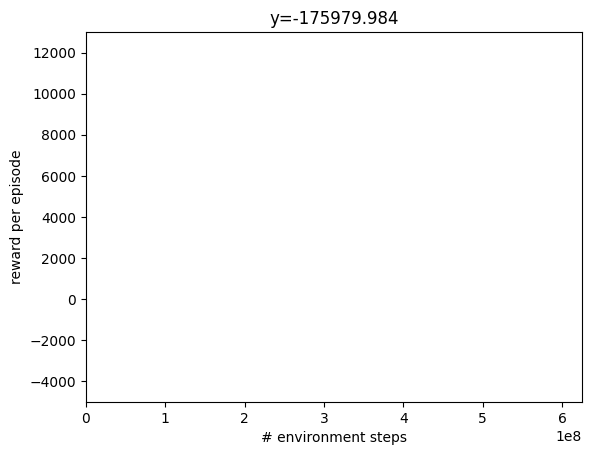

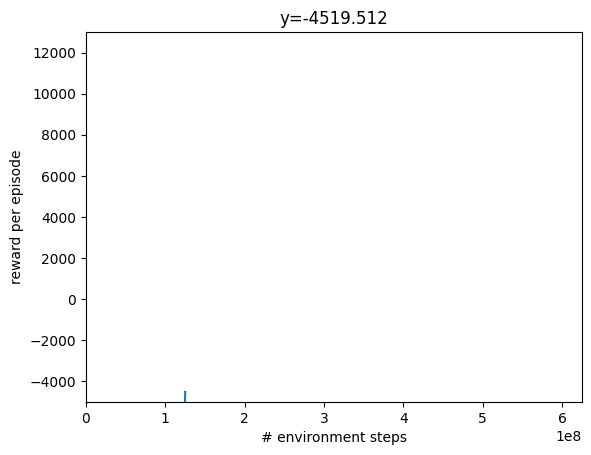

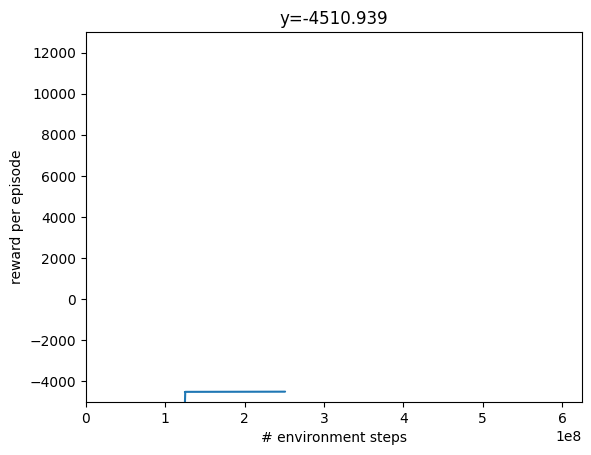

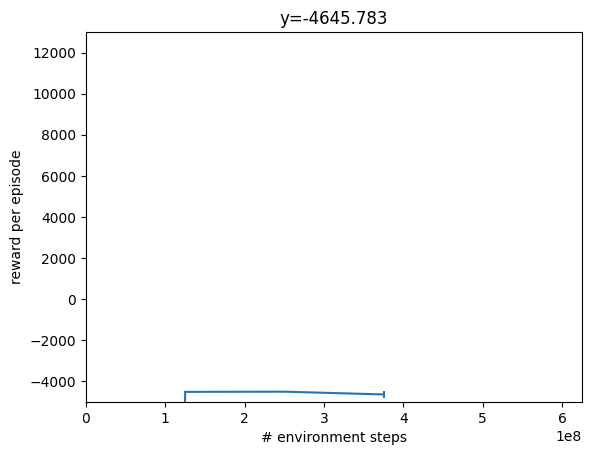

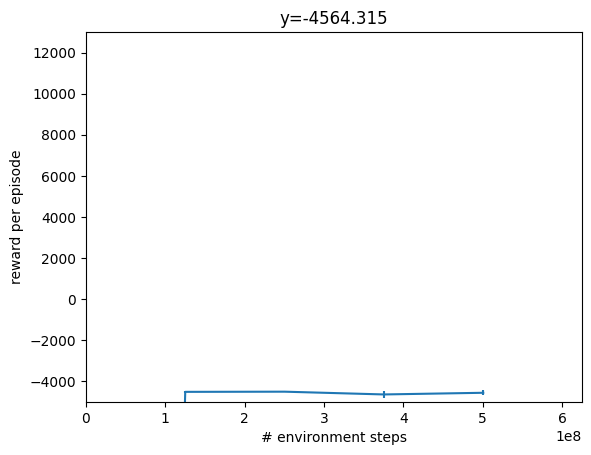

time to jit: 0:00:57.063057
time to train: 0:30:47.430052


In [ ]:
train_fn = functools.partial(
    ppo.train, num_timesteps=100_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, -5000
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
#@title Save Model
model_path = '/tmp/mjx_brax_policy'
model.save_params(model_path, params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [ ]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "column_link" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "shoulder_pitch" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "Arm1" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mujoco/mjx/_src/mesh.py:177: UserWarning: Mesh "Arm2" has a coplanar face with more than 20 vertices. This may lead to performance issues and ina

In [ ]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 150
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)
  # print(state.obs)

  # if state.done:
  #   break

media.show_video(env.render(rollout[::render_every]), fps=1.0 / env.dt / render_every)

# MJX Policy in MuJoCo

We can also perform the physics step using the original MuJoCo python bindings to show that the policy trained in MJX works in MuJoCo.

In [ ]:
mj_model = eval_env.sys.mj_model
mj_data = mujoco.MjData(mj_model)

renderer = mujoco.Renderer(mj_model)
ctrl = jp.zeros(mj_model.nu)

images = []
for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  obs = eval_env._get_obs(mjx.put_data(mj_model, mj_data), ctrl)
  ctrl, _ = jit_inference_fn(obs, act_rng)

  mj_data.ctrl = ctrl
  for _ in range(eval_env._n_frames):
    mujoco.mj_step(mj_model, mj_data)  # Physics step using MuJoCo mj_step.

  if i % render_every == 0:
    renderer.update_scene(mj_data)
    images.append(renderer.render())

media.show_video(images, fps=1.0 / eval_env.dt / render_every)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
